<a href="https://colab.research.google.com/github/Palash1011/neural-networks-from-scratch/blob/main/Neural_Networks_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork:
    def __init__(self, layer_dims, lr=0.001):
        self.layer_dims = layer_dims
        self.lr = lr
        self.L = len(layer_dims) - 1
        self.params = {}
        self.cache = {}
        self.m = {}
        self.v = {}
        self.t = 0
        self._init_weights()

    def _init_weights(self):
        for l in range(1, self.L + 1):
            self.params[f"W{l}"] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2 / self.layer_dims[l-1])
            self.params[f"b{l}"] = np.zeros((self.layer_dims[l], 1))
            self.m[f"W{l}"] = np.zeros_like(self.params[f"W{l}"])
            self.v[f"W{l}"] = np.zeros_like(self.params[f"W{l}"])

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_backward(self, dA, Z):
        dZ = dA.copy()
        dZ[Z <= 0] = 0
        return dZ

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def forward(self, X):
        A = X
        self.cache["A0"] = X
        for l in range(1, self.L):
            Z = self.params[f"W{l}"] @ A + self.params[f"b{l}"]
            A = self.relu(Z)
            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
        ZL = self.params[f"W{self.L}"] @ A + self.params[f"b{self.L}"]
        AL = self.softmax(ZL)
        self.cache[f"Z{self.L}"] = ZL
        self.cache[f"A{self.L}"] = AL
        return AL

    def compute_loss(self, Y_hat, Y):
      m = Y.shape[1]
      data_loss = -np.sum(Y * np.log(Y_hat + 1e-8)) / m

      l2 = 0
      for l in range(1, self.L + 1):
          l2 += np.sum(self.params[f"W{l}"]**2)

      return data_loss + 0.0005 * l2


    def backward(self, Y):
        grads = {}
        m = Y.shape[1]

        dZ = self.cache[f"A{self.L}"] - Y
        grads[f"dW{self.L}"] = (1/m) * dZ @ self.cache[f"A{self.L-1}"].T
        grads[f"db{self.L}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        for l in reversed(range(1, self.L)):
            dA = self.params[f"W{l+1}"].T @ dZ
            dZ = self.relu_backward(dA, self.cache[f"Z{l}"])
            grads[f"dW{l}"] = (1/m) * dZ @ self.cache[f"A{l-1}"].T
            grads[f"db{l}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        return grads

    def update_adam(self, grads, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        for l in range(1, self.L + 1):
            self.m[f"W{l}"] = beta1 * self.m[f"W{l}"] + (1-beta1) * grads[f"dW{l}"]
            self.v[f"W{l}"] = beta2 * self.v[f"W{l}"] + (1-beta2) * (grads[f"dW{l}"]**2)

            m_hat = self.m[f"W{l}"] / (1 - beta1**self.t)
            v_hat = self.v[f"W{l}"] / (1 - beta2**self.t)

            self.params[f"W{l}"] -= self.lr * m_hat / (np.sqrt(v_hat) + eps)
            self.params[f"b{l}"] -= self.lr * grads[f"db{l}"]


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, -1).T / 255.0
X_test = X_test.reshape(10000, -1).T / 255.0

y_train = to_categorical(y_train).T
y_test = to_categorical(y_test).T

In [4]:
model = NeuralNetwork([784, 256, 128, 10], lr=0.0008)

losses = []

batch_size = 128

for epoch in range(40):

    perm = np.random.permutation(X_train.shape[1])
    X_train = X_train[:, perm]
    y_train = y_train[:, perm]

    for i in range(0, X_train.shape[1], batch_size):
        Xb = X_train[:, i:i+batch_size]
        yb = y_train[:, i:i+batch_size]

        Y_hat = model.forward(Xb)
        grads = model.backward(yb)
        model.update_adam(grads)

    pred = model.forward(X_train)
    loss = model.compute_loss(pred, y_train)
    print(f"Epoch {epoch+1}, Loss = {loss}")

Epoch 1, Loss = 0.584472101858818
Epoch 2, Loss = 0.5882330151954
Epoch 3, Loss = 0.6094616942561298
Epoch 4, Loss = 0.6276820339055493
Epoch 5, Loss = 0.6662402214157002
Epoch 6, Loss = 0.6993549587706479
Epoch 7, Loss = 0.7316747116650802
Epoch 8, Loss = 0.775851489635547
Epoch 9, Loss = 0.7986066379831955
Epoch 10, Loss = 0.8379654187740955
Epoch 11, Loss = 0.8709321371041501
Epoch 12, Loss = 0.9127641684331853
Epoch 13, Loss = 0.9522006896739539
Epoch 14, Loss = 0.971857258208699
Epoch 15, Loss = 1.000250547008081
Epoch 16, Loss = 1.0584348574808529
Epoch 17, Loss = 1.0820730929761595
Epoch 18, Loss = 1.1165427751832775
Epoch 19, Loss = 1.1480629575005754
Epoch 20, Loss = 1.1788434915100223
Epoch 21, Loss = 1.1880680862572226
Epoch 22, Loss = 1.1933415387432205
Epoch 23, Loss = 1.2628270111342974
Epoch 24, Loss = 1.3077001844721223
Epoch 25, Loss = 1.3401618586549056
Epoch 26, Loss = 1.3573762465366677
Epoch 27, Loss = 1.3727480876780607
Epoch 28, Loss = 1.3842770140176792
Epoch 29

In [5]:
pred = model.forward(X_test)
accuracy = np.mean(np.argmax(pred, axis=0) == np.argmax(y_test, axis=0))
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9799


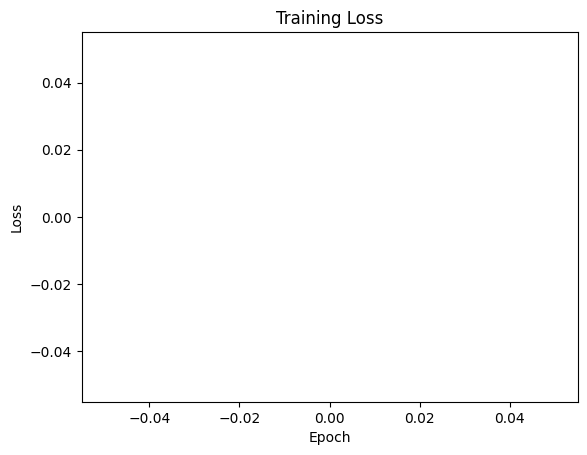

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()